Sea surface temperature (SST) is a critical parameter in understanding oceanographic and climatic processes. Predicting SST can aid in weather forecasting, climate change studies, and marine ecosystem management. This project utilizes an LSTM model, a type of recurrent neural network, to predict SST based on historical data.

# 1. Load Data and Dependencies

In [1]:
# Mount google drive & go to dataset folder

from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [2]:
# Install dependencies (if required)
!pip install netCDF4
!pip install cartopy
!pip install cmocean

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 9.8/9.8 MB 37.4 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.3/1.3 MB 47.3 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 11.6/11.6 MB 20.0 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 421.9/421.9 kB 4.1 MB/s eta 0:00:00


In [3]:
# Import necessary dependencies
import numpy as np
import xarray as xr
import matplotlib.pyplot as plt
import netCDF4 as nc
import pandas as pd
import seaborn as sns
import cartopy.crs as ccrs
import cartopy.feature as cfeature

from scipy.stats import pearsonr, spearmanr, zscore
from statsmodels.tsa.seasonal import seasonal_decompose
from sklearn.preprocessing import MinMaxScaler
from sklearn.decomposition import PCA
from sklearn.cluster import KMeans
import statsmodels.api as sm

import tensorflow as tf
import random
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Flatten, Dense
from tensorflow.keras.callbacks import EarlyStopping
from tensorflow.keras.optimizers import Adam
from sklearn.metrics import mean_absolute_error, r2_score

import cmocean

In [4]:
# Load dataset
file_path = "/content/drive/My Drive/data/CMEMS_Data_Temp/dataset-armor-3d-rep-monthly_1717495414175.nc"
dataset = xr.open_dataset(file_path, engine='netcdf4')

# 2. Explorotary Data Aanalysis

In [17]:
# Check the dataset

print('Dataset Information')
print(dataset)

Dataset Information
<xarray.Dataset>
Dimensions:    (depth: 1, latitude: 144, longitude: 136, time: 360)
Coordinates:
  * depth      (depth) float32 -0.0
  * latitude   (latitude) float32 26.12 26.38 26.62 26.88 ... 61.38 61.62 61.88
  * longitude  (longitude) float32 -20.88 -20.62 -20.38 ... 12.38 12.62 12.88
  * time       (time) datetime64[ns] 1993-01-01 1993-02-01 ... 2022-12-01
Data variables:
    mlotst     (time, latitude, longitude) float32 124.1 115.3 92.7 ... nan nan
    so         (time, depth, latitude, longitude) float32 37.0 36.99 ... nan nan
    to         (time, depth, latitude, longitude) float32 20.32 20.26 ... nan
    zo         (time, depth, latitude, longitude) float32 0.314 0.304 ... nan
Attributes:
    Conventions:       CF-1.11
    title:             ARMOR3D REP - TSHUVMld Global Ocean Observation-based ...
    institution:       CLS
    history:           1993-01-15 12:00:00 ARMOR3D REP - TSHUV Global Ocean O...
    subset:source:     ARCO data downloaded from 

In [18]:
# Check for missing values in each variable
missing_values = {}
for var in dataset.data_vars:
    missing_values[var] = dataset[var].isnull().sum().item()

# Print missing values information
print('Number of missing value in variables')
for var, count in missing_values.items():
    print(f"{var} has {count} missing values.")

Number of missing value in variables
mlotst has 2728882 missing values.
so has 2708586 missing values.
to has 2624400 missing values.
zo has 3078189 missing values.


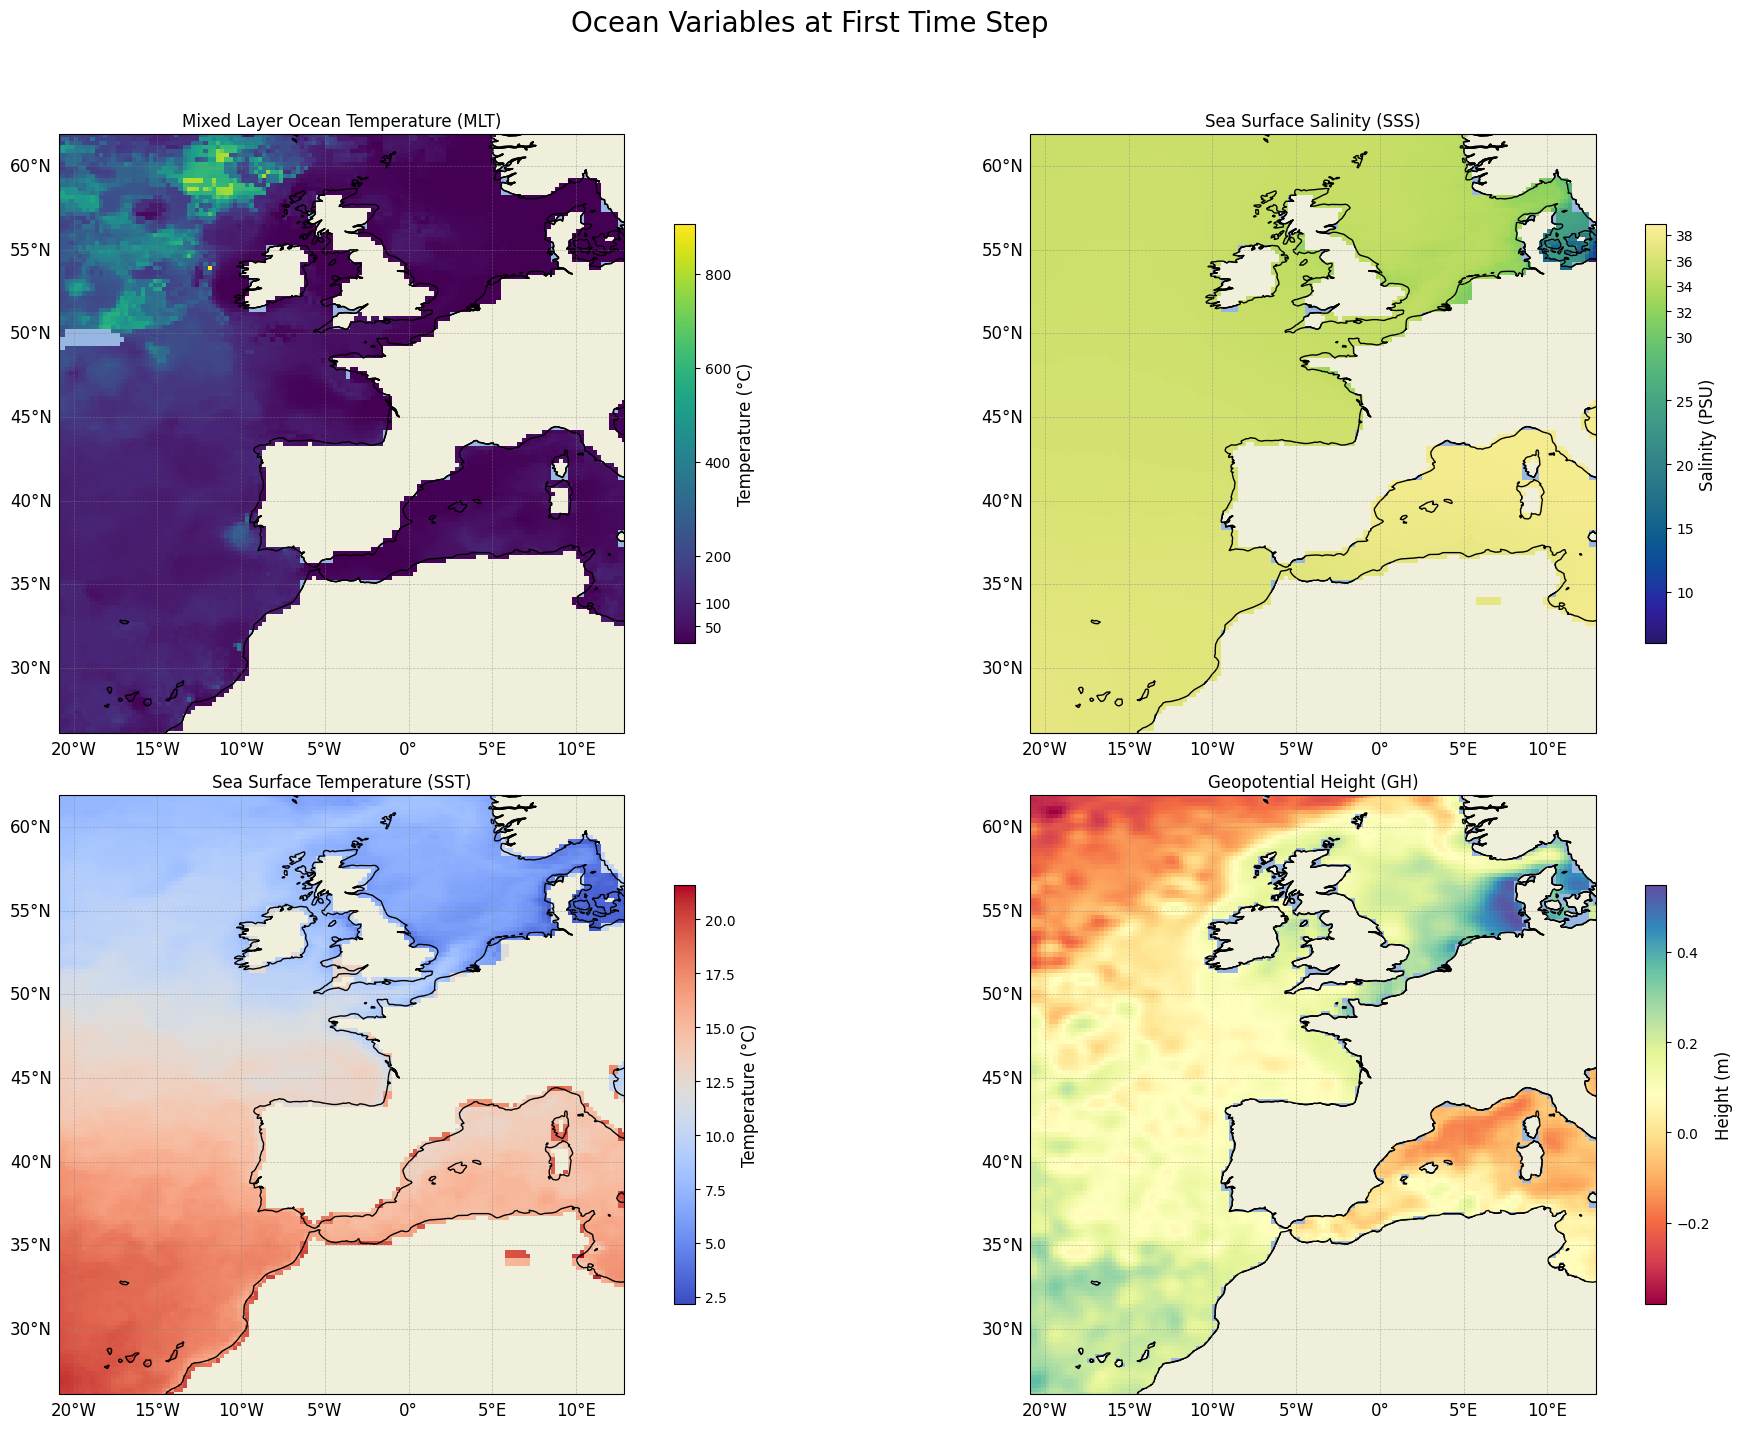

In [19]:
# Plotting : Check any time step for the variables

# Extract variables for the first time step
mlotst_data = dataset['mlotst'].isel(time=0).values                               # mixed layer depth
so_data = dataset['so'].isel(time=0, depth=0).values                              # sea surface salinity
to_data = dataset['to'].isel(time=0, depth=0).values                              # sea surface temperature
zo_data = dataset['zo'].isel(time=0, depth=0).values                              # geopotential height
latitude = dataset['latitude'].values
longitude = dataset['longitude'].values

# Plot
fig, axs = plt.subplots(2, 2, figsize=(20, 15), subplot_kw={'projection': ccrs.PlateCarree()})
axs = axs.flatten()

# Function to create a subplot
def create_subplot(ax, data, title, cmap, cbar_label, cbar_ticks=None):
    ax.set_global()
    ax.coastlines()
    ax.add_feature(cfeature.LAND, zorder=0, edgecolor='black')
    ax.add_feature(cfeature.OCEAN, zorder=0, edgecolor='black')
    ax.set_extent([-20.88, 12.88, 26.12, 61.88], crs=ccrs.PlateCarree())
    plot = ax.pcolormesh(longitude, latitude, data, cmap=cmap, transform=ccrs.PlateCarree())
    cbar = fig.colorbar(plot, ax=ax, orientation='vertical', shrink=0.7, pad=0.05, ticks=cbar_ticks)
    cbar.set_label(cbar_label, size=12)
    ax.set_title(title)
    gl = ax.gridlines(draw_labels=True, crs=ccrs.PlateCarree(), linewidth=0.5, color='gray', alpha=0.5, linestyle='--')
    gl.top_labels = False
    gl.right_labels = False
    gl.xlabel_style = {'size': 12}
    gl.ylabel_style = {'size': 12}

# Create subplots for each variable
create_subplot(axs[0], mlotst_data, 'Mixed Layer Ocean Temperature (MLT)', 'viridis', 'Temperature (°C)', cbar_ticks=[0, 50, 100, 200, 400, 600, 800, 1000])
create_subplot(axs[1], so_data, 'Sea Surface Salinity (SSS)', cmocean.cm.haline, 'Salinity (PSU)', cbar_ticks=[5, 10, 15, 20, 25, 30, 32, 34, 36, 38, 40])
create_subplot(axs[2], to_data, 'Sea Surface Temperature (SST)', 'coolwarm', 'Temperature (°C)')
create_subplot(axs[3], zo_data, 'Geopotential Height (GH)', 'Spectral', 'Height (m)')

plt.suptitle('Ocean Variables at First Time Step', fontsize=20)
plt.tight_layout(rect=[0, 0.03, 1, 0.95])
plt.show()

Sea Surface Temperature data analysis

In [20]:
# Descriptive statistics for Temperature

# Extract sea surface temperature data
sst_data = dataset['to'].isel(depth=0).values                                       # Surface level

# Descriptive statistics
mean_temp = np.nanmean(sst_data)
std_temp = np.nanstd(sst_data)
median_temp = np.nanmedian(sst_data)
min_temp = np.nanmin(sst_data)
max_temp = np.nanmax(sst_data)

print(f"Mean: {mean_temp}, Std: {std_temp}, Median: {median_temp}, Min: {min_temp}, Max: {max_temp}")

Mean: 15.131413459777832, Std: 4.82240104675293, Median: 14.831000328063965, Min: -1.2999999523162842, Max: 31.207000732421875


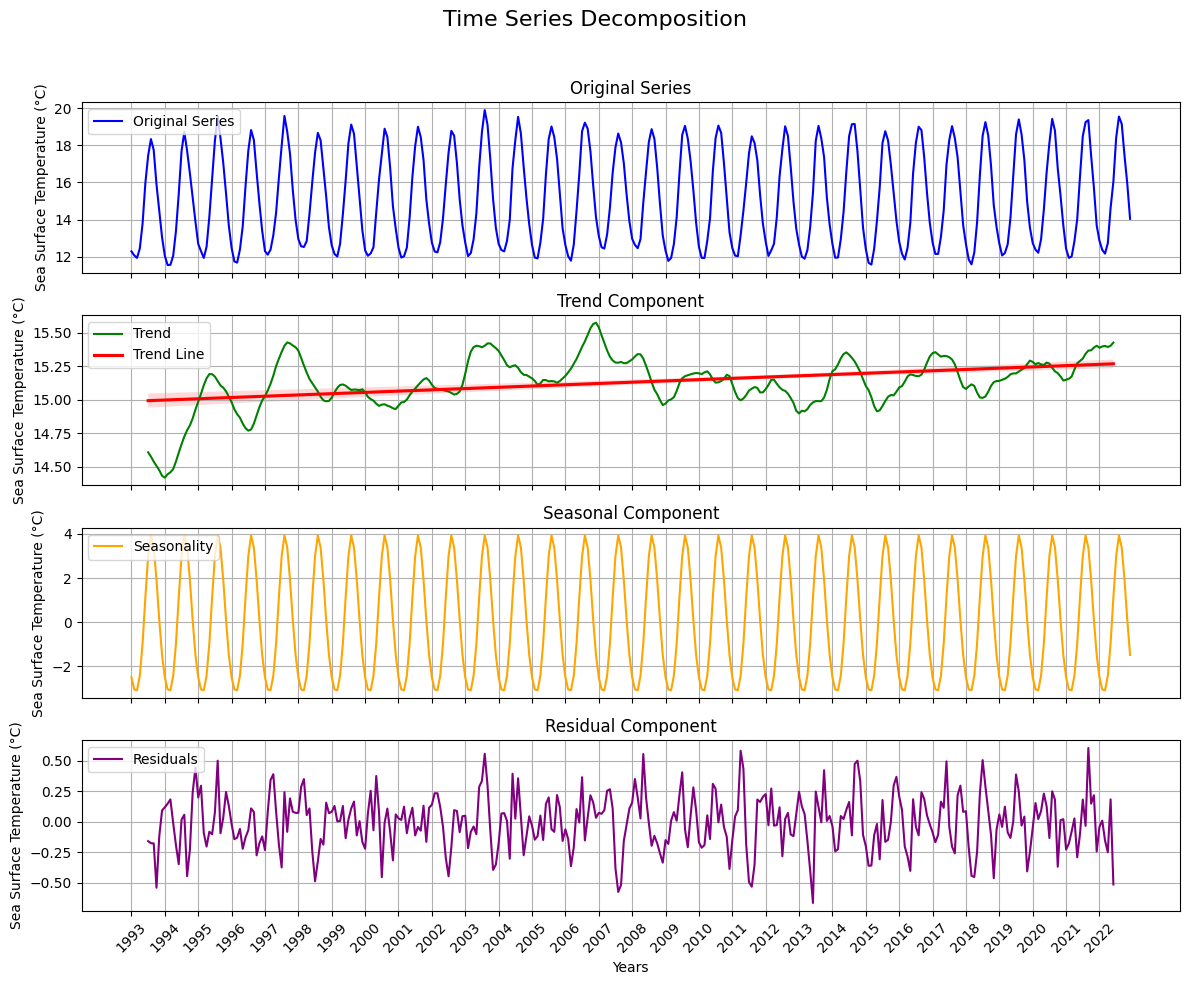

In [21]:
# Time Series Analysis

# Extract the time data (years) from the dataset
time_data = pd.to_datetime(dataset['time'].values)
years = time_data.year

# Calculate the average SST over all latitude and longitude for each time step for the domain
sst_time_series = np.nanmean(sst_data, axis=(1, 2))                               # Ignore NaNs in the domain

# Decompose the time series to observe trend, seasonality, and residuals
result = seasonal_decompose(sst_time_series, period=12, model='additive')

# Plot the decomposed components
fig, axes = plt.subplots(4, 1, figsize=(12, 10), sharex=True)

# Original Series
axes[0].plot(result.observed, label='Original Series', color='blue')
axes[0].set_title('Original Series')
axes[0].legend(loc='upper left')

# Trend Component
axes[1].plot(result.trend, label='Trend', color='green')
sns.regplot(x=np.arange(len(result.trend)), y=result.trend, ax=axes[1], scatter=False, color='red', label='Trend Line')
axes[1].set_title('Trend Component')
axes[1].legend(loc='upper left')

# Seasonal Component
axes[2].plot(result.seasonal, label='Seasonality', color='orange')
axes[2].set_title('Seasonal Component')
axes[2].legend(loc='upper left')

# Residuals Component
axes[3].plot(result.resid, label='Residuals', color='purple')
axes[3].set_title('Residual Component')
axes[3].legend(loc='upper left')

# Set x-ticks to years
axes[3].set_xticks(np.arange(len(years))[::12])
axes[3].set_xticklabels(years[::12], rotation=45)

# Add overall title and labels
fig.suptitle('Time Series Decomposition', fontsize=16)
for ax in axes:
    ax.set_ylabel('Sea Surface Temperature (°C)')
    ax.grid(True)

axes[-1].set_xlabel('Years')
plt.tight_layout(rect=[0, 0, 1, 0.96])
plt.show()

Number of anomalies detected: 24
Anomalous values: [19.574167 19.578009 19.114069 18.997824 19.893093 19.1035   19.526924
 19.011288 19.215002 19.045107 19.057844 19.020823 19.04554  19.13334
 19.142807 18.996368 19.028942 19.246666 19.391232 19.420454 19.241074
 19.354702 19.54719  19.152401]


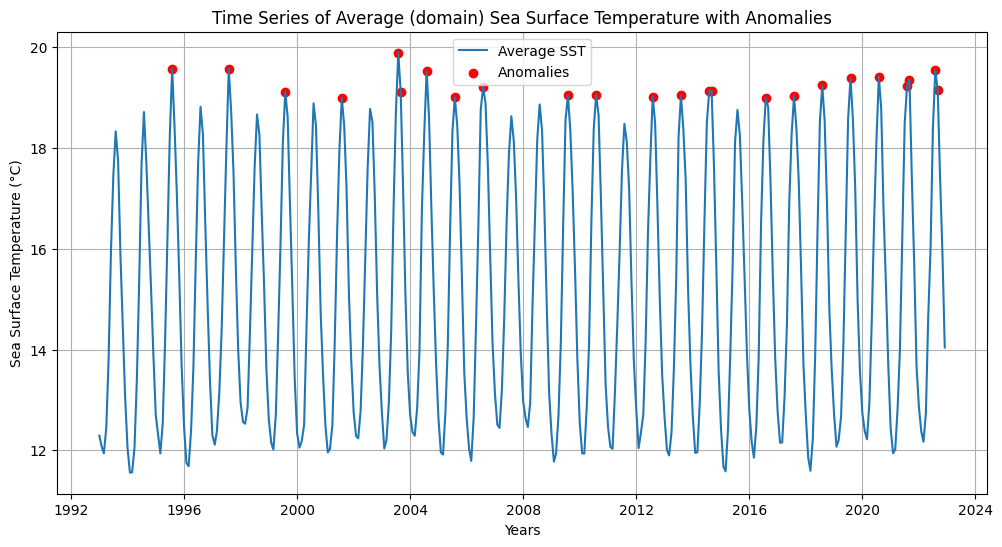

In [22]:
# Anomaly detection: over the region

# Compute z-scores for the time series
z_scores = zscore(sst_time_series)                                                # Use the previously calculated domain average

# Detect anomalies (e.g., z-score > 1.5 or < -1.5 degrees)                        # One can use other values to detect anomaly too
anomalies = np.where(np.abs(z_scores) > 1.5)                                      # Here +- 1.5 degrees is used
anomalous_values = sst_time_series[anomalies]
num_anomalies = len(anomalous_values)

print(f"Number of anomalies detected: {num_anomalies}")
print(f"Anomalous values: {anomalous_values}")

# Plot the time series with anomalies
plt.figure(figsize=(12, 6))
plt.plot(time_data, sst_time_series, label='Average SST')
plt.scatter(time_data[anomalies], sst_time_series[anomalies], color='red', label='Anomalies')
plt.xlabel('Years')
plt.ylabel('Sea Surface Temperature (°C)')
plt.title('Time Series of Average (domain) Sea Surface Temperature with Anomalies')
plt.legend()
plt.grid(True)
plt.show()

# # Summarize statistics of anomalies
# mean_anomaly = np.mean(anomalous_values)
# std_anomaly = np.std(anomalous_values)
# min_anomaly = np.min(anomalous_values)
# max_anomaly = np.max(anomalous_values)

# print(f"Mean of anomalies: {mean_anomaly}")
# print(f"Standard deviation of anomalies: {std_anomaly}")
# print(f"Minimum anomaly value: {min_anomaly}")
# print(f"Maximum anomaly value: {max_anomaly}")


# Model: LSTM

In [12]:
# Prepare data for Machine learning

# Extract sea surface temperature data
sst_data = dataset['to'].isel(depth=0).values                                       # Surface level

# Reshape data - Scale the data - Deal with NaN values

# Flatten the data for scaling
flattened_data = sst_data.reshape(sst_data.shape[0], -1)
print(f'Flattened Sea Surface Temperature Data Shape: {flattened_data.shape}')

# Fill NaNs with the mean value of each feature
col_means = np.nanmean(flattened_data, axis=0)
nan_indices = np.where(np.isnan(flattened_data))
flattened_data[nan_indices] = np.take(col_means, nan_indices[1])
print(f'Flattened Sea Surface Temperature Data Shape after filling NaNs: {flattened_data.shape}')

# Scale the data
scaler = MinMaxScaler(feature_range=(0, 1))
scaled_data = scaler.fit_transform(flattened_data)
print(f'Scaled Sea Surface Temperature Data Shape: {scaled_data.shape}')

# Remove all-NaN columns
all_nan_columns = np.isnan(scaled_data).all(axis=0)
valid_columns = ~all_nan_columns
scaled_data = scaled_data[:, valid_columns]
print(f'Scaled Sea Surface Temperature Data Shape after removing all-NaN columns: {scaled_data.shape}')

Flattened Sea Surface Temperature Data Shape: (360, 19584)
Flattened Sea Surface Temperature Data Shape after filling NaNs: (360, 19584)


<ipython-input-12-a4b5f5c4bc69>:13: RuntimeWarning: Mean of empty slice
  col_means = np.nanmean(flattened_data, axis=0)
/usr/local/lib/python3.10/dist-packages/sklearn/preprocessing/_data.py:473: RuntimeWarning: All-NaN slice encountered
  data_min = np.nanmin(X, axis=0)
/usr/local/lib/python3.10/dist-packages/sklearn/preprocessing/_data.py:474: RuntimeWarning: All-NaN slice encountered
  data_max = np.nanmax(X, axis=0)


Scaled Sea Surface Temperature Data Shape: (360, 19584)
Scaled Sea Surface Temperature Data Shape after removing all-NaN columns: (360, 12294)


In [13]:
# Split the Data for ML

# Split the data into training and testing sets (e.g., 80% train, 20% test)
train_size = int(scaled_data.shape[0] * 0.8)
train_data = scaled_data[:train_size, :]
test_data = scaled_data[train_size:, :]
print(f'Train Data Shape: {train_data.shape}')
print(f'Test Data Shape: {test_data.shape}')

# Prepare the data for LSTM
timesteps = 12                                                                    # Adjust the timesteps as needed
X_train, y_train = [], []
X_test, y_test = [], []

for i in range(timesteps, train_data.shape[0]):
    X_train.append(train_data[i-timesteps:i, :])
    y_train.append(train_data[i, :])

for i in range(timesteps, test_data.shape[0]):
    X_test.append(test_data[i-timesteps:i, :])
    y_test.append(test_data[i, :])

X_train, y_train = np.array(X_train), np.array(y_train)
X_test, y_test = np.array(X_test), np.array(y_test)
print(f'Training Data Shape: {X_train.shape}')
print(f'Training Labels Shape: {y_train.shape}')
print(f'Testing Data Shape: {X_test.shape}')
print(f'Testing Labels Shape: {y_test.shape}')

Train Data Shape: (288, 12294)
Test Data Shape: (72, 12294)
Training Data Shape: (276, 12, 12294)
Training Labels Shape: (276, 12294)
Testing Data Shape: (60, 12, 12294)
Testing Labels Shape: (60, 12294)


In [14]:
# Define the Model and train it

# Set random seed for reproducibility
np.random.seed(42)
tf.random.set_seed(42)

# Define the LSTM model
model = Sequential()
model.add(LSTM(50, return_sequences=True, input_shape=(X_train.shape[1], X_train.shape[2])))
model.add(LSTM(50))
model.add(Dense(y_train.shape[1]))

model.compile(optimizer='adam', loss='mean_squared_error')

# Define EarlyStopping callback
early_stopping = EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True)

# Train the model
history = model.fit(X_train, y_train, epochs=100, batch_size=32, validation_split=0.2, callbacks=[early_stopping])

# Evaluate the model
loss = model.evaluate(X_test, y_test)
print(f'Test Loss: {loss}')

Epoch 1/100
7/7 [==============================] - 7s 399ms/step - loss: 0.2310 - val_loss: 0.1943
Epoch 2/100
7/7 [==============================] - 2s 335ms/step - loss: 0.1357 - val_loss: 0.0922
Epoch 3/100
7/7 [==============================] - 2s 302ms/step - loss: 0.0734 - val_loss: 0.0773
Epoch 4/100
7/7 [==============================] - 2s 320ms/step - loss: 0.0756 - val_loss: 0.0731
Epoch 5/100
7/7 [==============================] - 2s 349ms/step - loss: 0.0672 - val_loss: 0.0708
Epoch 6/100
7/7 [==============================] - 1s 180ms/step - loss: 0.0665 - val_loss: 0.0716
Epoch 7/100
7/7 [==============================] - 1s 173ms/step - loss: 0.0644 - val_loss: 0.0677
Epoch 8/100
7/7 [==============================] - 1s 176ms/step - loss: 0.0625 - val_loss: 0.0656
Epoch 9/100
7/7 [==============================] - 1s 169ms/step - loss: 0.0607 - val_loss: 0.0640
Epoch 10/100
7/7 [==============================] - 1s 173ms/step - loss: 0.0583 - val_loss: 0.0620
Epoch 11/

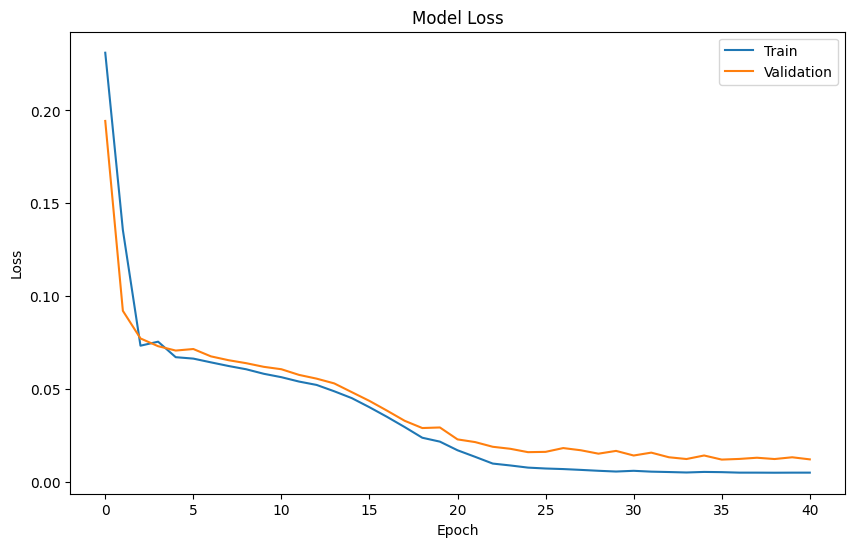

2/2 [==============================] - 2s 141ms/step
Predictions Shape: (60, 12294)
Predictions shape: (737640,)
Actuals shape: (737640,)


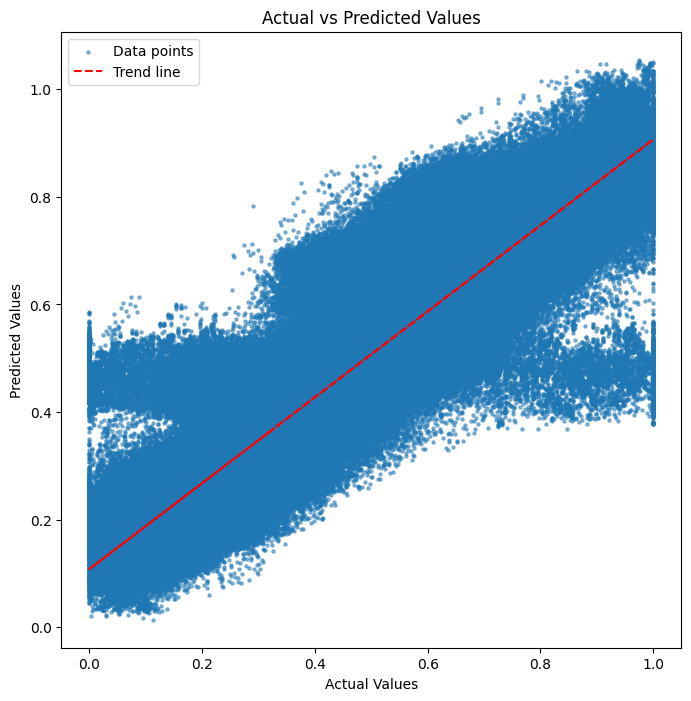

Mean Absolute Error: 0.07990172505378723
R-squared: 0.8428280647638976


In [15]:
# Define functions for plotting and evaluation

# Plot training & validation loss
def plot_loss(history):
    plt.figure(figsize=(10, 6))
    plt.plot(history.history['loss'])
    plt.plot(history.history['val_loss'])
    plt.title('Model Loss')
    plt.xlabel('Epoch')
    plt.ylabel('Loss')
    plt.legend(['Train', 'Validation'], loc='upper right')
    plt.show()

# Evaluate the model
def evaluate_model(model, X_test, y_test):
    predictions = model.predict(X_test)
    print(f'Predictions Shape: {predictions.shape}')

    # Flatten the predictions and actual values
    predictions_flat = predictions.flatten()
    actuals_flat = y_test.flatten()

    # Check shapes to ensure they are the same
    print(f"Predictions shape: {predictions_flat.shape}")
    print(f"Actuals shape: {actuals_flat.shape}")

    # Scatter plot of actual vs predicted values with a trend line
    plt.figure(figsize=(8, 8))                                                    # Ensure square shape
    plt.scatter(actuals_flat, predictions_flat, s=5, alpha=0.5, label='Data points')

    # Add a trend line
    z = np.polyfit(actuals_flat, predictions_flat, 1)
    p = np.poly1d(z)
    plt.plot(actuals_flat, p(actuals_flat), "r--", label='Trend line')

    plt.xlabel('Actual Values')
    plt.ylabel('Predicted Values')
    plt.title('Actual vs Predicted Values')
    plt.legend()
    plt.show()

    # Calculate additional metrics
    mae = mean_absolute_error(actuals_flat, predictions_flat)
    r2 = r2_score(actuals_flat, predictions_flat)

    print(f'Mean Absolute Error: {mae}')
    print(f'R-squared: {r2}')

    return predictions_flat, actuals_flat, mae, r2

# Plot training & validation loss
plot_loss(history)
# Print out the MAE and R2
predictions, actuals, mae, r2 = evaluate_model(model, X_test, y_test)


The low MAE and high R² values collectively suggest that the LSTM model performs well in predicting sea surface temperature. The model's predictions are generally close to the actual values, and it captures a significant portion of the variability in the data. These results indicate that the LSTM model is effective for this time series forecasting task.

1/1 [==============================] - 0s 49ms/step


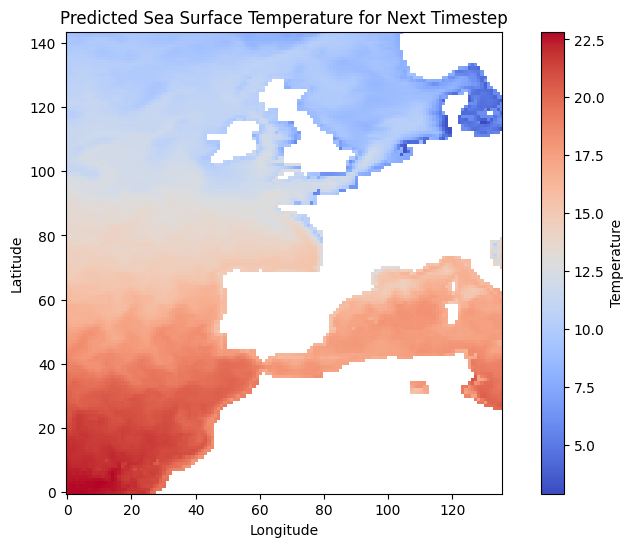

In [16]:
# Prediction for the next timestep

# Predict
def predict_next_timestep(model, X_test):
    last_sequence = X_test[-1]  # Get the last sequence from the test set
    last_sequence = np.expand_dims(last_sequence, axis=0)  # Reshape to add batch dimension

    next_timestep_prediction = model.predict(last_sequence)
    return next_timestep_prediction.flatten()  # Flatten directly

# Example usage to predict next timestep
next_timestep_prediction = predict_next_timestep(model, X_test)

# Inverse transform the predictions back to the original scale
# Create an empty array to fill with the scaled data shape (360, 12294)
inverse_transformed_data = np.full((scaled_data.shape[0], len(valid_columns)), np.nan)
inverse_transformed_data[:, valid_columns] = scaled_data

# Transform back the predicted data
next_timestep_original_scale = scaler.inverse_transform(inverse_transformed_data[-1, :].reshape(1, -1))
next_timestep_original_scale = next_timestep_original_scale[0, valid_columns]

# Reconstructing the spatial data
original_shape = (144, 136)                                                       # Replace with the original spatial shape (lat, lon)

def reconstruct_spatial_data(prediction, valid_columns, original_shape):
    spatial_data = np.full(original_shape, np.nan)
    spatial_data.ravel()[valid_columns] = prediction
    return spatial_data

# Example usage to reconstruct spatial data
next_timestep_spatial = reconstruct_spatial_data(next_timestep_original_scale, valid_columns, original_shape)

# Plot the spatial data
plt.figure(figsize=(10, 6))
plt.imshow(next_timestep_spatial, cmap='coolwarm', origin='lower')
plt.colorbar(label='Temperature')
plt.title('Predicted Sea Surface Temperature for Next Timestep')
plt.xlabel('Longitude')
plt.ylabel('Latitude')
plt.show()

/usr/local/lib/python3.10/dist-packages/cartopy/io/__init__.py:241: DownloadWarning: Downloading: https://naturalearth.s3.amazonaws.com/50m_physical/ne_50m_land.zip
  warnings.warn(f'Downloading: {url}', DownloadWarning)
/usr/local/lib/python3.10/dist-packages/cartopy/io/__init__.py:241: DownloadWarning: Downloading: https://naturalearth.s3.amazonaws.com/50m_physical/ne_50m_ocean.zip
  warnings.warn(f'Downloading: {url}', DownloadWarning)
/usr/local/lib/python3.10/dist-packages/cartopy/io/__init__.py:241: DownloadWarning: Downloading: https://naturalearth.s3.amazonaws.com/50m_physical/ne_50m_coastline.zip
  warnings.warn(f'Downloading: {url}', DownloadWarning)


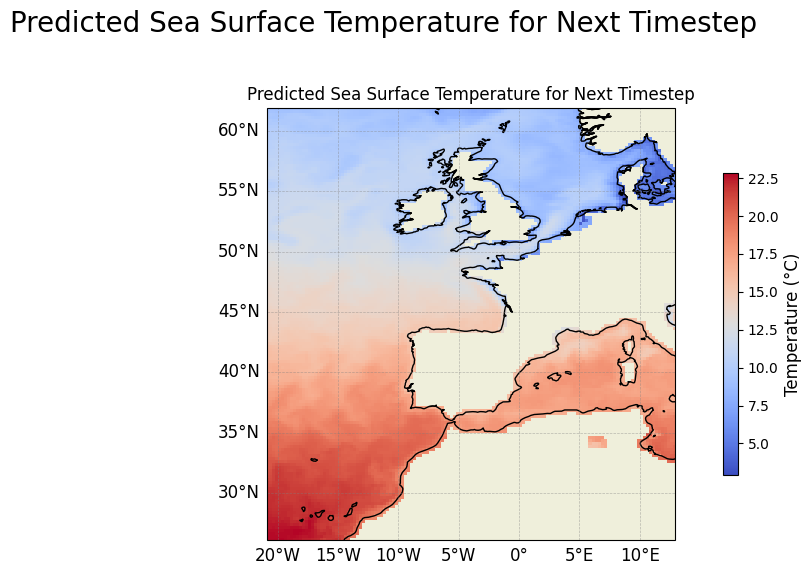

In [11]:
# Plot with coastline

latitude = dataset['latitude'].values
longitude = dataset['longitude'].values

# Define the function to create a subplot
def create_subplot(ax, data, title, cmap, cbar_label, cbar_ticks=None):
    ax.set_global()
    ax.coastlines()
    ax.add_feature(cfeature.LAND, zorder=0, edgecolor='black')
    ax.add_feature(cfeature.OCEAN, zorder=0, edgecolor='black')
    ax.set_extent([-20.88, 12.88, 26.12, 61.88], crs=ccrs.PlateCarree())
    plot = ax.pcolormesh(longitude, latitude, data, cmap=cmap, transform=ccrs.PlateCarree())
    cbar = fig.colorbar(plot, ax=ax, orientation='vertical', shrink=0.7, pad=0.05, ticks=cbar_ticks)
    cbar.set_label(cbar_label, size=12)
    ax.set_title(title)
    gl = ax.gridlines(draw_labels=True, crs=ccrs.PlateCarree(), linewidth=0.5, color='gray', alpha=0.5, linestyle='--')
    gl.top_labels = False
    gl.right_labels = False
    gl.xlabel_style = {'size': 12}
    gl.ylabel_style = {'size': 12}

# Plot the predicted Sea Surface Temperature (SST) for the next time step
fig, ax = plt.subplots(figsize=(10, 6), subplot_kw={'projection': ccrs.PlateCarree()})
create_subplot(ax, next_timestep_spatial, 'Predicted Sea Surface Temperature for Next Timestep', 'coolwarm', 'Temperature (°C)')

plt.suptitle('Predicted Sea Surface Temperature for Next Timestep', fontsize=20)
plt.tight_layout(rect=[0, 0.03, 1, 0.95])
plt.show()
